In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.cm as cm

In [74]:
#unit in seconds
#Parameters
numodors = 2

k1 = np.zeros(numodors)
km1 = np.zeros(numodors)
k2 = np.zeros(numodors)
km2 = np.zeros(numodors)
kappa= np.zeros(numodors)
eta = np.zeros(numodors)

k1[0] = 1/(0.010)
km1[0] = 1/(0.010) 
k2[0] = 1/(0.5)
km2[0] = 1/(0.5)

kappa[0] = (km1[0]/k1[0])*(km2[0]/k2[0])/(1.0 + (km2[0]/k2[0]))

#agonist
k1[1] = 0.8/(0.010)
km1[1] = 1/(0.010) 
k2[1] = 0.2/(0.5)
km2[1] = 1/(0.5)
#antagonist
# k1[1] = 5.0/(0.010)
# km1[1] = 1/(0.010) 
# k2[1] = 0.2/(0.5)
# km2[1] = 1/(0.5)

kappa[1] = (km1[1]/k1[1])*(km2[1]/k2[1])/(1.0 + (km2[1]/k2[1]))

KC = 1/(0.5)
delC = 1/(1)

kG = 10

KCa = 1/(0.050)
delCa = 1/(2)

KCaM = 1/(1)
delCaM = 1/(3)

R0 = 1
n = 4
CaM0 = 0.05
nini = 2

eta[0] = KC*kG*R0/(1.0 + (km2[0]/k2[0]))
eta[1] = KC*kG*R0/(1.0 + (km2[1]/k2[1]))

In [6]:
def response_odor(c, eta, kappa):
    return 1.0/(1.0 + ((1.0 + c/kappa)/(eta*c/kappa))**n)

def response_mixture(c, eta, kappa):
    kappa_sum = 1.0 + np.sum(c/kappa, axis = 0)
    etakappa_sum = np.sum(c*eta/kappa, axis = 0)
    return 1.0/(1.0 + (kappa_sum/etakappa_sum)**n)


def integrate(T,dt, Xc, stimtime, secpulsetime, secpulse, k1,k2,km1,km2, odorindex):
    numsteps = int((T+1)/dt)
    times = np.linspace(-1,T,numsteps)
    R = np.zeros(numsteps)
    R[0]= R0
    B = np.zeros(numsteps)
    A = np.zeros(numsteps)

    C = np.zeros(numsteps)
    CNG = np.zeros(numsteps)

    Ca = np.zeros(numsteps)
    CaM = np.zeros(numsteps)
    
    X = Xc*np.zeros(numsteps)
    for i in range(numsteps):
        if times[i] < 0:
            continue
        if times[i] < stimtime:
            X[i] = Xc
        elif secpulse == 1 and times[i] > stimtime + secpulsetime and times[i] < stimtime + secpulsetime + stimtime:
            X[i] = Xc

    for i in range(1,numsteps):
        R[i] = R[i-1] + dt*(km1[odorindex]*B[i-1] - k1[odorindex]*R[i-1]*X[i-1])
        B[i] = B[i-1] + dt*(k1[odorindex]*R[i-1]*X[i-1] + km2[odorindex]*A[i-1] - km1[odorindex]*B[i-1] - k2[odorindex]*B[i-1])
        A[i] = A[i-1] + dt*(k2[odorindex]*B[i-1] - km2[odorindex]*A[i-1])

        C[i] = C[i-1] + dt*(KC*A[i-1] - delC*C[i-1])

        CNG[i] = (C[i-1]**n)/(C[i-1]**n + ((1.0 + (CaM[i-1]/CaM0)**nini)/kG)**n)
        Ca[i] = Ca[i-1] + dt*(KCa*CNG[i-1] - delCa*Ca[i-1] - KCaM*Ca[i-1])
        CaM[i] = CaM[i-1] + dt*(KCaM*Ca[i-1] - delCaM*CaM[i-1])
    return C, Ca#, CaM , CNG

def integrate_mix(T,dt, Xc, stimtime, secpulsetime, secpulse, k1,k2,km1,km2, numodors):
    numsteps = int((T+1)/dt)
    times = np.linspace(-1,T,numsteps)
    R = np.zeros(numsteps)
    R[0]= R0
    B = np.zeros((numodors,numsteps))
    A = np.zeros((numodors,numsteps))

    C = np.zeros(numsteps)
    CNG = np.zeros(numsteps)

    Ca = np.zeros(numsteps)
    CaM = np.zeros(numsteps)
    
    X = Xc*np.zeros(numsteps)
    for i in range(numsteps):
        if times[i] < 0:
            continue
        if times[i] < stimtime:
            X[i] = Xc/numodors
        elif secpulse == 1 and times[i] > stimtime + secpulsetime and times[i] < stimtime + secpulsetime + stimtime:
            X[i] = Xc/numodors

    for i in range(1,numsteps):
        sumR = 0
        sumA = 0
        for j in range(numodors):
            sumR += km1[j]*B[j][i-1] - k1[j]*R[i-1]*X[i-1]
            B[j][i] = B[j][i-1] + dt*(k1[j]*R[i-1]*X[i-1] + km2[j]*A[j][i-1] - km1[j]*B[j][i-1] - k2[j]*B[j][i-1])
            A[j][i] = A[j][i-1] + dt*(k2[j]*B[j][i-1] - km2[j]*A[j][i-1])
            sumA += A[j][i]
            
        R[i] = R[i-1] + dt*(sumR)

        C[i] = C[i-1] + dt*(KC*sumA - delC*C[i-1])

        CNG[i] = (C[i-1]**n)/(C[i-1]**n + ((1.0 + (CaM[i-1]/CaM0)**nini)/kG)**n)
        Ca[i] = Ca[i-1] + dt*(KCa*CNG[i-1] - delCa*Ca[i-1] - KCaM*Ca[i-1])
        CaM[i] = CaM[i-1] + dt*(KCaM*Ca[i-1] - delCaM*CaM[i-1])
    return C, Ca 

def integrate_mix_c_2odors(T,dt, Xc, stimtime, secpulsetime, secpulse, k1,k2,km1,km2):
    numodors = 2
    numsteps = int((T+1)/dt)
    times = np.linspace(-1,T,numsteps)
    R = np.zeros(numsteps)
    R[0]= R0
    B = np.zeros((numodors,numsteps))
    A = np.zeros((numodors,numsteps))

    C = np.zeros(numsteps)
    CNG = np.zeros(numsteps)

    Ca = np.zeros(numsteps)
    CaM = np.zeros(numsteps)
    
    X = np.zeros((numodors,numsteps))
    for i in range(numsteps):
        if times[i] < 0:
            continue
        if times[i] < stimtime:
            X[0,i] = Xc[0]
        if secpulse == 1:
            if times[i] > stimtime + secpulsetime and times[i] < stimtime + secpulsetime + stimtime:
                X[1,i] = Xc[1]
        else:
            X[1,i] = Xc[1]
        

    for i in range(1,numsteps):
        sumR = 0
        sumA = 0
        for j in range(numodors):
            sumR += km1[j]*B[j][i-1] - k1[j]*R[i-1]*X[j,i-1]
            B[j][i] = B[j][i-1] + dt*(k1[j]*R[i-1]*X[j,i-1] + km2[j]*A[j][i-1] - km1[j]*B[j][i-1] - k2[j]*B[j][i-1])
            A[j][i] = A[j][i-1] + dt*(k2[j]*B[j][i-1] - km2[j]*A[j][i-1])
            sumA += A[j][i]
            
        R[i] = R[i-1] + dt*(sumR)

        C[i] = C[i-1] + dt*(KC*sumA - delC*C[i-1])

        CNG[i] = (C[i-1]**n)/(C[i-1]**n + ((1.0 + (CaM[i-1]/CaM0)**nini)/kG)**n)
        Ca[i] = Ca[i-1] + dt*(KCa*CNG[i-1] - delCa*Ca[i-1] - KCaM*Ca[i-1])
        CaM[i] = CaM[i-1] + dt*(KCaM*Ca[i-1] - delCaM*CaM[i-1])
    return C, Ca 

0.0181436439112 0.00127296957265
0.0676783604734 0.0625818683888
0.122977892054 0.737545231548
0.19410036378 0.98634694338
0.270336963067 0.998730580073
0.330944193013 0.999682720747
0.365645218383 0.999833451624
0.381192369578 0.999871509652
0.387304900716 0.999883443894
0.389577451012 0.999887522342


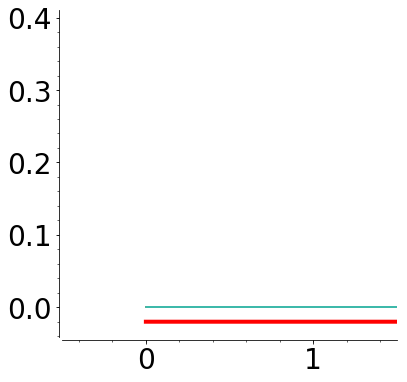

In [13]:
#Test block
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

Xconcs = 100

dt = 0.0001
T = 10
stimtime = 4
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)
numt = 10
Cs = np.zeros((numt,numsteps))
Cas = np.zeros((numt,numsteps))
CaM = np.zeros((numt,numsteps))
#k2[0] = 0.05/(0.5)
Xconcs = np.logspace(-2,2,numt)
for i in range(numt):
    #k2[0] = 0.02*(i+1)/0.5
    KCaM = 1/(1)
    Cs[i],Cas[i],CaM[i], CNG = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 0)
    temp1 = np.max(CaM)
    axis.plot(CaM[i])
    KCaM = 0
    Cs[i],Cas[i],CaM[i], CNG = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 0)
    print(temp1, np.max(CNG))   
        
stim = times[(times < stimtime)*(times > 0)]
axis.plot(stim , -0.02*np.ones(len(stim)), 'r-', lw = 4, alpha = 1)
#axis.set_ylim(-0.03,0.8)
axis.set_xlim(-0.5,1.5)
#axis.set_xlabel("Time (seconds)", fontsize = 18)
#axis.set_ylabel("Response", fontsize = 18)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
#axis.get_yaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.01))
axis.spines['bottom'].set_position(('axes', -0.01))
axis.tick_params(axis='both', which='major', labelsize=28)

axis.xaxis.set_major_locator(MultipleLocator(1))
axis.xaxis.set_minor_locator(MultipleLocator(0.2))

axis.yaxis.set_minor_locator(MultipleLocator(0.02))
axis.yaxis.set_major_locator(MultipleLocator(0.1))
plt.show()

In [32]:
#Fig1 Panel 1: Response time series for difference concentrations
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

num = 6
Xconcs = np.logspace(-1.5,1.5,num)

dt = 0.0001
T = 5
stimtime = 0.5
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs = np.zeros((num, numsteps))
Cas = np.zeros((num, numsteps))

for i in range(len(Xconcs)):
    Cs[i],Cas[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 0)
    #axis.plot(times, Cs[i], 'r-')
    axis.plot(times, Cas[i], '-', lw = 3, alpha = 0.7)
stim = times[(times < stimtime)*(times > 0)]
axis.plot(stim , -0.02*np.ones(len(stim)), 'r-', lw = 4, alpha = 1)
axis.set_ylim(-0.03,0.75)
axis.set_xlim(-0.5,T)
#axis.set_xlabel("Time (seconds)", fontsize = 18)
#axis.set_ylabel("Response", fontsize = 18)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.get_yaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.01))
axis.spines['bottom'].set_position(('axes', -0.01))
axis.tick_params(axis='both', which='major', labelsize=28)

axis.xaxis.set_major_locator(MultipleLocator(1))
axis.xaxis.set_minor_locator(MultipleLocator(0.2))

axis.yaxis.set_minor_locator(MultipleLocator(0.02))
axis.yaxis.set_major_locator(MultipleLocator(0.1))
fig.savefig("fig1p1.eps", dpi = 200)

In [131]:
#Fig1 Panel 2: Adaptation 
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (10,6))

num = 4

Xc = 1

dt = 0.0001
T = 22
stimtime = 0.5
secpulsetimes = [5,9,13,17]
secpulse = 1

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs = np.zeros((num, numsteps))
Cas = np.zeros((num, numsteps))

for i in range(num):
    Cs[i],Cas[i] = integrate(T,dt,Xc, stimtime, secpulsetimes[i],secpulse,k1,k2,km1,km2, 0)
    #axis.plot(times, Cs[i], 'r-')
    axis.plot(times, Cas[i], 'k-', color = 'gray', lw = 5, alpha = 0.8)
    if i == num-1:
        axis.plot(times[times<4], Cas[i][times<4], 'k-', lw = 5, alpha = 0.6)
    secstim = times[(times > secpulsetimes[i] + stimtime)*(times < secpulsetimes[i] + 2*stimtime)]
    axis.plot(secstim , -0.025*np.ones(len(secstim)), 'r-', lw = 7, alpha = 1)
    
stim = times[(times < stimtime)*(times > 0)]
axis.plot(stim , -0.02*np.ones(len(stim)), 'r-', lw = 6, alpha = 1)
axis.set_ylim(-0.03,0.75)
axis.set_xlim(-1,T)
#axis.set_xlabel("Time (seconds)", fontsize = 18)
#axis.set_ylabel("Response", fontsize = 18)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))

axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )

axis.spines['left'].set_bounds(0,0.75)
axis.spines['bottom'].set_bounds(0,20)
axis.set_xticks([0,10,20])
axis.yaxis.set_major_locator(MultipleLocator(0.25))
axis.xaxis.set_major_locator(MultipleLocator(10))

fig.savefig("fig1p2.eps", dpi = 200)

In [132]:
#Fig1 Panel 3: Adaptation part 2
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

num = 40

Xc = 1

dt = 0.001
T = 15
stimtimes = np.linspace(0,0.8,num)
secpulsetime = 10
secpulse = 1

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs = np.zeros((num, numsteps))
Cas = np.zeros((num, numsteps))

for i in range(num):
    Cs[i],Cas[i] = integrate(T,dt,Xc, stimtimes[i], secpulsetime,secpulse,k1,k2,km1,km2, 0)
    
axis.plot(stimtimes , np.max(Cas, axis = 1), 'k-', lw = 5, alpha = 1)
axis.plot(stimtimes , np.max(Cas[:,times > 5], axis = 1), 'k--', lw = 5, alpha = 1)
#axis.set_ylim(-0.03,0.35)
#axis.set_xlim(-1,T)
#axis.set_xlabel("Stimulus time (seconds)", fontsize = 18)
#axis.set_ylabel("Response", fontsize = 18)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))

axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )

axis.spines['left'].set_bounds(0,0.6)
axis.spines['bottom'].set_bounds(0,0.8)
axis.xaxis.set_major_locator(MultipleLocator(0.4))
axis.yaxis.set_major_locator(MultipleLocator(0.2))

fig.savefig("fig1p3.eps", dpi = 200)

In [41]:
#Fig1 Panel 4: Rate of cAMP
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

num = 6
Xconcs = np.logspace(-1.5,1.5,num)

dt = 0.0001
T = 5
stimtime = 0.5
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs = np.zeros((num, numsteps))
Cas = np.zeros((num, numsteps))

for i in range(len(Xconcs)):
    Cs[i],Cas[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 0)
    stimindex = (times < 0.2)*(times > 0)
    axis.plot((times[stimindex])[1:]*1000 , ((Cs[i][stimindex])[1:] - (Cs[i][stimindex])[:-1])/dt  , '-', lw = 3, alpha = 1)

#axis.set_ylim(-0.03,0.45)
axis.set_xlim(-0.20,200)
#axis.set_xlabel("Time (seconds)", fontsize = 18)
#axis.set_ylabel("cAMP production rate", fontsize = 18)

axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.get_yaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.01))
axis.spines['bottom'].set_position(('axes', -0.01))
axis.tick_params(axis='both', which='major', labelsize=28)

axis.xaxis.set_major_locator(MultipleLocator(100))
axis.xaxis.set_minor_locator(MultipleLocator(20))

axis.yaxis.set_minor_locator(MultipleLocator(0.02))
axis.yaxis.set_major_locator(MultipleLocator(0.1))
fig.savefig("fig1p4.eps", dpi = 200)

In [133]:
#Fig1 Panel 5: Latency
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

num = 20
Xconcs = np.logspace(-1,2,num)

dt = 0.0001
T = 5
stimtime = 0.5
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs = np.zeros((num, numsteps))
Cas = np.zeros((num, numsteps))
riseCastimes = np.zeros(num)
fallCastimes = np.zeros(num)
for i in range(len(Xconcs)):
    print(i)
    Cs[i],Cas[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 0)
    for j in range(len(Cas[i])):
        if Cas[i][j] > 0.1*np.max(Cas[i]):
            riseCastimes[i] = times[j]
            break
    for j in range(len(Cas[i])):
        if Cas[i][j] < 0.1*np.max(Cas[i]) and times[j] > riseCastimes[i]:
            fallCastimes[i] = times[j]
            break
axis.semilogx(Xconcs, riseCastimes, '-', lw = 6, alpha = 1)
#axis.semilogx(Xconcs, fallCastimes - riseCastimes, '--', color = 'gray', lw = 5, alpha = 1)
axis.semilogx(Xconcs, riseCastimes[-1]*np.ones(num), '--', lw = 6, alpha = 1)
axis.set_ylim(0,0.7)
axis.set_xlim(Xconcs[0]/3,Xconcs[-1]*3)
#axis.set_ylim(0,0.6)
#axis.set_xlabel("Concentration", fontsize = 18)
#axis.set_ylabel("Latency (seconds)", fontsize = 18)

axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))

axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )

axis.spines['left'].set_bounds(0,0.6)
axis.spines['bottom'].set_bounds(1e-1,1e2)
axis.set_xticks([1e-1,1e0,1e1,1e2])
axis.yaxis.set_major_locator(MultipleLocator(0.3))
#fig.tight_layout()
fig.savefig("fig1p5.eps", dpi = 200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [134]:
#Fig1 Panel 6: Response time series for 2 odors and mixture
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

num = 1
Xc = 1

dt = 0.001
T = 5
stimtime = 0.5
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs1 = np.zeros((numsteps))
Cas1 = np.zeros((numsteps))

Cs2 = np.zeros((numsteps))
Cas2 = np.zeros((numsteps))

Cs12 = np.zeros((numsteps))
Cas12 = np.zeros((numsteps))

Cs1,Cas1 = integrate(T,dt,Xc, stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 0)
Cs2,Cas2 = integrate(T,dt,Xc, stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 1)
Cs12,Cas12 = integrate_mix(T,dt,Xc, stimtime, secpulsetime,secpulse,k1,k2,km1,km2,2)

axis.plot(times, Cas1, 'r-', lw = 5, alpha = 1)
axis.plot(times, Cas2, 'b-', lw = 5, alpha = 1)
axis.plot(times, Cas12, 'm-',  lw = 5, alpha = 1)
stim = times[(times < stimtime)*(times > 0)]
axis.plot(stim , -0.025*np.ones(len(stim)), 'r-',  lw = 8, alpha = 1)#,color = '#71B855')
axis.set_ylim(-0.03,0.65)
axis.set_xlim(-0.5,T)
#axis.set_xlabel("Time (seconds)", fontsize = 18)
#axis.set_ylabel("Response", fontsize = 18)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))

axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )


axis.spines['left'].set_bounds(0,0.6)
axis.spines['bottom'].set_bounds(0,4)
axis.xaxis.set_major_locator(MultipleLocator(2))
axis.xaxis.set_minor_locator(MultipleLocator(0.2))

axis.yaxis.set_minor_locator(MultipleLocator(0.02))
axis.yaxis.set_major_locator(MultipleLocator(0.2))
fig.savefig("fig1p6.eps", dpi = 200)

In [135]:
#Fig1 Panel 7: Concentration curves of odors and mixtures: antagonistic
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

num = 40
Xconcs = np.logspace(-2,2,num)

dt = 0.0001
T = 5
stimtime = 0.5
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs1 = np.zeros((num,numsteps))
Cas1 = np.zeros((num,numsteps))

Cs2 = np.zeros((num,numsteps))
Cas2 = np.zeros((num,numsteps))

Cs12 = np.zeros((num,numsteps))
Cas12 = np.zeros((num,numsteps))

for i in range(len(Xconcs)):
    print(i)
    Cs1[i],Cas1[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 0)
    Cs2[i],Cas2[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 1)
    Cs12[i],Cas12[i] = integrate_mix(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 2)
    
axis.semilogx(Xconcs, np.max(Cas1,axis=1), 'r-', lw = 5, alpha = 1)
axis.semilogx(Xconcs, np.max(Cas2,axis=1), 'b-', lw = 5, alpha = 1)
axis.semilogx(Xconcs, np.max(Cas12,axis=1), 'm-', lw = 5, alpha = 1)
    
#axis.set_ylim(-0.03,0.75)
#axis.set_xlim(-0.5,T)
#axis.set_xlabel("Concentration", fontsize = 18)
#axis.set_ylabel("Response", fontsize = 18)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_linewidth(4)
axis.spines['bottom'].set_linewidth(4)
axis.get_yaxis().set_ticklabels([])
axis.get_xaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.05))
axis.spines['bottom'].set_position(('axes', -0.05))

axis.tick_params(which = 'major', length = 10,width = 3, direction = 'out' )
axis.tick_params(which = 'minor', length = 0, direction = 'out' )

axis.spines['left'].set_bounds(0,0.75)
axis.spines['bottom'].set_bounds(1e-2,1e2)
axis.yaxis.set_major_locator(MultipleLocator(0.25))
axis.set_xticks([1e-2,1e0,1e2])
#axis.xaxis.set_major_locator(MultipleLocator(0.1))
fig.savefig("fig1p7.eps", dpi = 200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [54]:
#Fig1 Panel 8: Concentration curves of odors and mixtures: non-antagonistic
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (6,6))

num = 40
Xconcs = np.logspace(-1.5,2,num)

dt = 0.001
T = 5
stimtime = 0.5
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs1 = np.zeros((num,numsteps))
Cas1 = np.zeros((num,numsteps))

Cs2 = np.zeros((num,numsteps))
Cas2 = np.zeros((num,numsteps))

Cs12 = np.zeros((num,numsteps))
Cas12 = np.zeros((num,numsteps))

for i in range(len(Xconcs)):
    Cs1[i],Cas1[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 0)
    Cs2[i],Cas2[i] = integrate(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 1)
    Cs12[i],Cas12[i] = integrate_mix(T,dt,Xconcs[i], stimtime, secpulsetime,secpulse,k1,k2,km1,km2, 2)
    
axis.semilogx(Xconcs, np.max(Cas1,axis=1), 'r-', lw = 3, alpha = 0.7)
axis.semilogx(Xconcs, np.max(Cas2,axis=1), 'b-', lw = 3, alpha = 0.7)
axis.semilogx(Xconcs, np.max(Cas12,axis=1), 'm-', lw = 3, alpha = 0.7)
    
#axis.set_ylim(-0.03,0.75)
#axis.set_xlim(-0.5,T)
#axis.set_xlabel("Concentration", fontsize = 18)
#axis.set_ylabel("Response", fontsize = 18)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.get_yaxis().set_ticklabels([])
axis.spines['left'].set_position(('axes', -0.01))
axis.spines['bottom'].set_position(('axes', -0.01))
axis.tick_params(axis='both', which='major', labelsize=28)

axis.yaxis.set_minor_locator(MultipleLocator(0.02))
axis.yaxis.set_major_locator(MultipleLocator(0.1))
fig.savefig("fig1p8.eps", dpi = 200)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:81: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/pytho

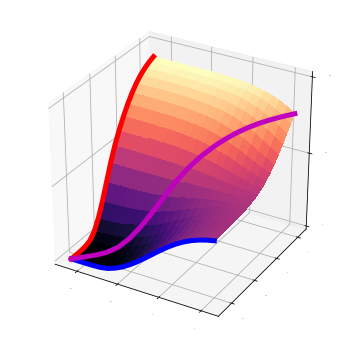

In [107]:
#Fig1 Panel 9: Concentration curves of odors and mixtures: antagonistic: 3D plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = ['Tahoma']
plt.close("all")

fig = plt.figure(figsize = (6,6))
axis = fig.add_subplot(111, projection='3d')

num = 20
Xconcs = np.logspace(-2,1,num)

dt = 0.0003
T = 3
stimtime = 0.5
secpulsetime = 8
secpulse = 0

numsteps = int((T+1)/dt)
times = np.linspace(-1,T,numsteps)

Cs12 = np.zeros((num,num,numsteps))
Cas12 = np.zeros((num,num,numsteps))

mix = np.zeros(len(Xconcs))
for i in range(len(Xconcs)):
    for j in range(len(Xconcs)):
        Cs12[i,j],Cas12[i,j] = integrate_mix_c_2odors(T,dt,[Xconcs[i],Xconcs[j]], stimtime, secpulsetime,secpulse,k1,k2,km1,km2)
x,y = np.meshgrid(Xconcs,Xconcs)
#axis.xaxis.set_scale("log")
#axis.yaxis.set_scale("log")
axis.set_zlim(0,0.81)
axis.zaxis.set_major_locator(MultipleLocator(0.4))
axis.zaxis.set_minor_locator(MultipleLocator(0.08))

axis.yaxis.set_major_locator(MultipleLocator(2))
axis.yaxis.set_minor_locator(MultipleLocator(0.4))

axis.xaxis.set_major_locator(MultipleLocator(2))
axis.xaxis.set_minor_locator(MultipleLocator(0.4))
#axis.view_init(30, angle)
surf = axis.plot_surface(np.log(x) ,np.log(y) , np.max(Cas12, axis = 2),cmap=cm.magma, linewidth=0, antialiased=False)
axis.plot(np.log(x[0]) ,np.log(y[0]) , np.max(Cas12, axis = 2)[0,:], color = 'b', linewidth = 5)
axis.plot(np.log(y[0]) ,np.log(x[0]) , np.max(Cas12, axis = 2)[:,0], color = 'r', linewidth = 5)
mix = np.zeros(len(Xconcs))
for i in range(len(Xconcs)):
    mix[i] =  np.max(Cas12, axis = 2)[i,i]
axis.plot(np.log(x[0]) ,np.log(x[0]) , mix, color = 'm', linewidth = 5)
for t in axis.zaxis.get_major_ticks(): t.label.set_fontsize(0)
for t in axis.xaxis.get_major_ticks(): t.label.set_fontsize(0)
for t in axis.yaxis.get_major_ticks(): t.label.set_fontsize(0)

fig.savefig("fig1p9.pdf")
plt.show()